In [1]:
!pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/93/21/9b035a4f823d6aee2917c75415be9a95861ff3d73a0a65e48edbf210cec1/tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata (3.6 kB)
  Obtaining dependency information for tensorflow-intel==2.15.0 from https://files.pythonhosted.org/packages/4c/48/1a5a15517f18eaa4ff8d598b1c000300b20c1bb0e624539d702117a0c369/tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata (5.1 kB)
Using cached tensorflow-2.15.0-cp311-cp311-win_amd64.whl (2.1 kB)
Using cached tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl (300.9 MB)



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import string
import re
import emoji
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB


from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import GlobalMaxPooling1D,Embedding,Dense, LSTM

from sklearn.metrics import accuracy_score
nltk.download('stopwords')
nltk.download('vader_lexicon')
stemmer = nltk.SnowballStemmer("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
!pip install spacy


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# 데이터 불러오기
data = pd.read_csv('./reviews_data.csv')

data.head()

name           location                     Date  Rating  \
0     Helen  Wichita Falls, TX  Reviewed Sept. 13, 2023     5.0   
1  Courtney         Apopka, FL   Reviewed July 16, 2023     5.0   
2  Daynelle  Cranberry Twp, PA    Reviewed July 5, 2023     5.0   
3    Taylor        Seattle, WA    Reviewed May 26, 2023     5.0   
4   Tenessa        Gresham, OR   Reviewed Jan. 22, 2023     5.0   

                                              Review  \
0  Amber and LaDonna at the Starbucks on Southwes...   
1  ** at the Starbucks by the fire station on 436...   
2  I just wanted to go out of my way to recognize...   
3  Me and my friend were at Starbucks and my card...   
4  I’m on this kick of drinking 5 cups of warm wa...   

                                         Image_Links  
0                                      ['No Images']  
1                                      ['No Images']  
2  ['https://media.consumeraffairs.com/files/cach...  
3                                      ['No Images']  
4  ['https://media.consumeraffairs.com/files/cach...

In [3]:
# 리뷰 분석에 사용하지 않는 Image_Links 제거

data.drop('Image_Links', axis=1, inplace=True)
data.head()

name           location                     Date  Rating  \
0     Helen  Wichita Falls, TX  Reviewed Sept. 13, 2023     5.0   
1  Courtney         Apopka, FL   Reviewed July 16, 2023     5.0   
2  Daynelle  Cranberry Twp, PA    Reviewed July 5, 2023     5.0   
3    Taylor        Seattle, WA    Reviewed May 26, 2023     5.0   
4   Tenessa        Gresham, OR   Reviewed Jan. 22, 2023     5.0   

                                              Review  
0  Amber and LaDonna at the Starbucks on Southwes...  
1  ** at the Starbucks by the fire station on 436...  
2  I just wanted to go out of my way to recognize...  
3  Me and my friend were at Starbucks and my card...  
4  I’m on this kick of drinking 5 cups of warm wa...

In [4]:
# 데이터 중 review가 없는 행을 제거
data = data[data['Review'] != 'No Review Text']

# 순서가 일관되게 재지정
data = data.reset_index(drop=True)
data.head()

name           location                     Date  Rating  \
0     Helen  Wichita Falls, TX  Reviewed Sept. 13, 2023     5.0   
1  Courtney         Apopka, FL   Reviewed July 16, 2023     5.0   
2  Daynelle  Cranberry Twp, PA    Reviewed July 5, 2023     5.0   
3    Taylor        Seattle, WA    Reviewed May 26, 2023     5.0   
4   Tenessa        Gresham, OR   Reviewed Jan. 22, 2023     5.0   

                                              Review  
0  Amber and LaDonna at the Starbucks on Southwes...  
1  ** at the Starbucks by the fire station on 436...  
2  I just wanted to go out of my way to recognize...  
3  Me and my friend were at Starbucks and my card...  
4  I’m on this kick of drinking 5 cups of warm wa...

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 813 entries, 0 to 812
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      813 non-null    object 
 1   location  813 non-null    object 
 2   Date      813 non-null    object 
 3   Rating    703 non-null    float64
 4   Review    813 non-null    object 
dtypes: float64(1), object(4)
memory usage: 31.9+ KB


In [6]:
import os
from dateutil import parser

# 날짜 데이터의 Review, . , 의 단어를 ''로 대체
data['Date'] = data['Date'].str.replace('Reviewed', '').str.replace('[.,]', '')

# 날짜 형식으로 변환
data['Date'] = data['Date'].apply(parser.parse)

In [7]:
data.head()

name           location       Date  Rating  \
0     Helen  Wichita Falls, TX 2023-09-13     5.0   
1  Courtney         Apopka, FL 2023-07-16     5.0   
2  Daynelle  Cranberry Twp, PA 2023-07-05     5.0   
3    Taylor        Seattle, WA 2023-05-26     5.0   
4   Tenessa        Gresham, OR 2023-01-22     5.0   

                                              Review  
0  Amber and LaDonna at the Starbucks on Southwes...  
1  ** at the Starbucks by the fire station on 436...  
2  I just wanted to go out of my way to recognize...  
3  Me and my friend were at Starbucks and my card...  
4  I’m on this kick of drinking 5 cups of warm wa...

In [10]:
!pip install missingno


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


<Axes: >

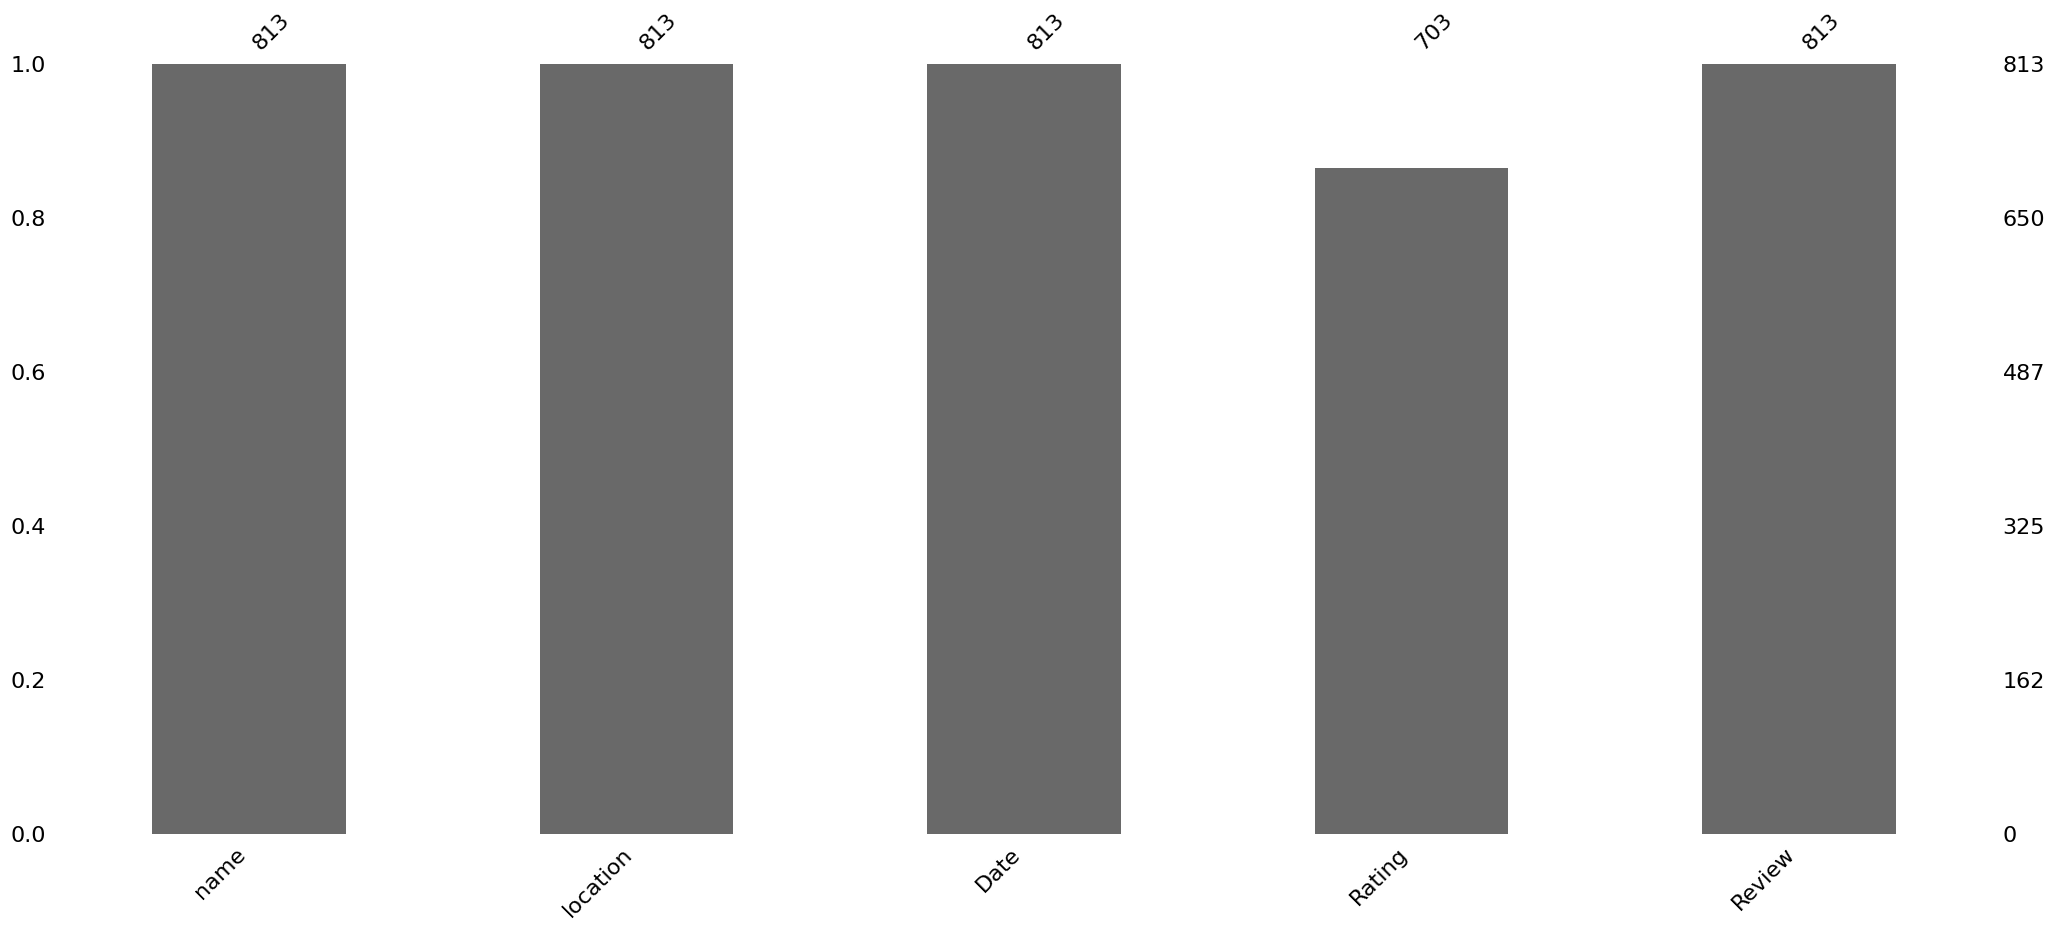

In [8]:
import missingno as msno

# 결측치 확인
# 110개의 결측치를 확인할 수 있다.
msno.bar(data)

C:\Users\user\AppData\Local\Temp\ipykernel_20616\1886855587.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Rating",data=data, palette="Set3")


<Axes: xlabel='Rating', ylabel='count'>

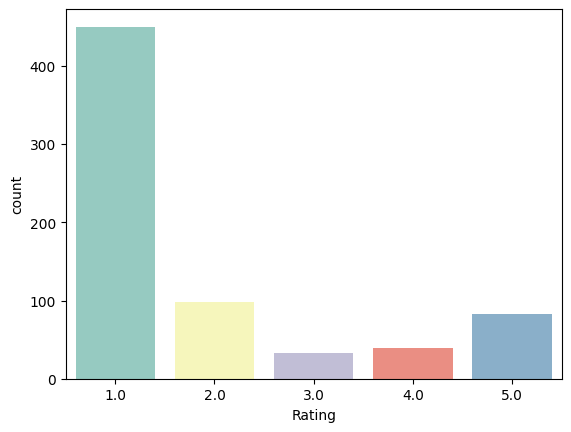

In [9]:
# 리뷰의 개수 파악하기
sns.countplot(x="Rating",data=data, palette="Set3")

In [10]:
# 3 초과의 리뷰는 긍정(1), 3미만의 숫자는 부정(2), 3은 중립(0)으로 라벨링을 진행
data["Rating"]=data["Rating"].replace([1,2],2)
data["Rating"]=data["Rating"].replace(3,0)
data["Rating"]=data["Rating"].replace([4,5],1)
data = data.dropna(axis = 0, how ='any')
data["Rating"]=data["Rating"].astype(int)

In [ ]:
positive =' '.join([i for i in data['Review'][df_clean['Rain\g'] > data["Negative"]]])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="black").generate(positive)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [11]:
# 라벨링 개수 파악
data["Rating"].value_counts()

Rating
2    548
1    122
0     33
Name: count, dtype: int64

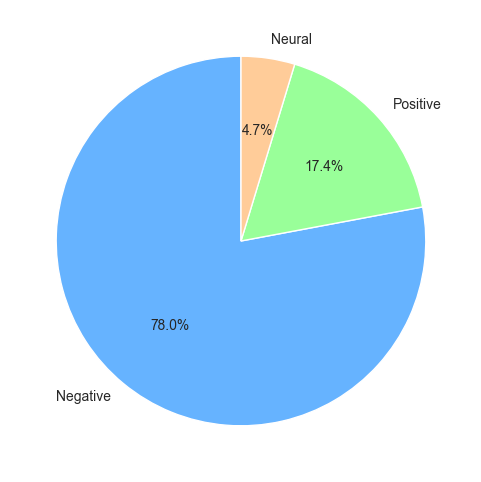

In [12]:
# 파이차트로 분포 확인 -> 부정적인 리뷰의 개수가 더 많음
plt.figure(figsize=(6, 6))
sns.set_style("whitegrid")
plt.pie(data["Rating"].value_counts(),labels=["Negative","Positive","Neural"], autopct='%1.1f%%',colors=['#66b3ff', '#99ff99', '#ffcc99'] , startangle=90);

In [13]:
# location 분류
data["location"]=data["location"].str.split(",").str[1]

In [14]:
import plotly.express as px

categorical_columns = ['location']

for column in categorical_columns:
    top_10_categories = data['location'].value_counts().head(10)
    top_10_df = pd.DataFrame({'Category': top_10_categories.index, 'Frequency': top_10_categories.values})
    
    fig = px.bar(
        top_10_df,
        x='Category',
        y='Frequency',
        title=f'Top 10 Categories in {column}',
        labels={'Category': column, 'Frequency': 'Frequency'},
        color='Category',
        color_discrete_sequence=px.colors.qualitative.Set3 
    )
    
    fig.update_layout(
        xaxis=dict(title=column),
        yaxis=dict(title='Frequency'),
        xaxis_tickangle=-90,  
        showlegend=False  
    )
    
    fig.show()

In [15]:
df = data[["location","Rating"]]
df["Negative"] = df[df["Rating"]==2]["Rating"]
df["Positive"] = df[df["Rating"]==1]["Rating"]
df["Neutral"] = df[df["Rating"]==0]["Rating"]
df.drop("Rating",axis=1,inplace=True)
df=df.groupby("location").count().sort_values(ascending= False,by='Negative').head(9)

C:\Users\user\AppData\Local\Temp\ipykernel_20616\1161851911.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\user\AppData\Local\Temp\ipykernel_20616\1161851911.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



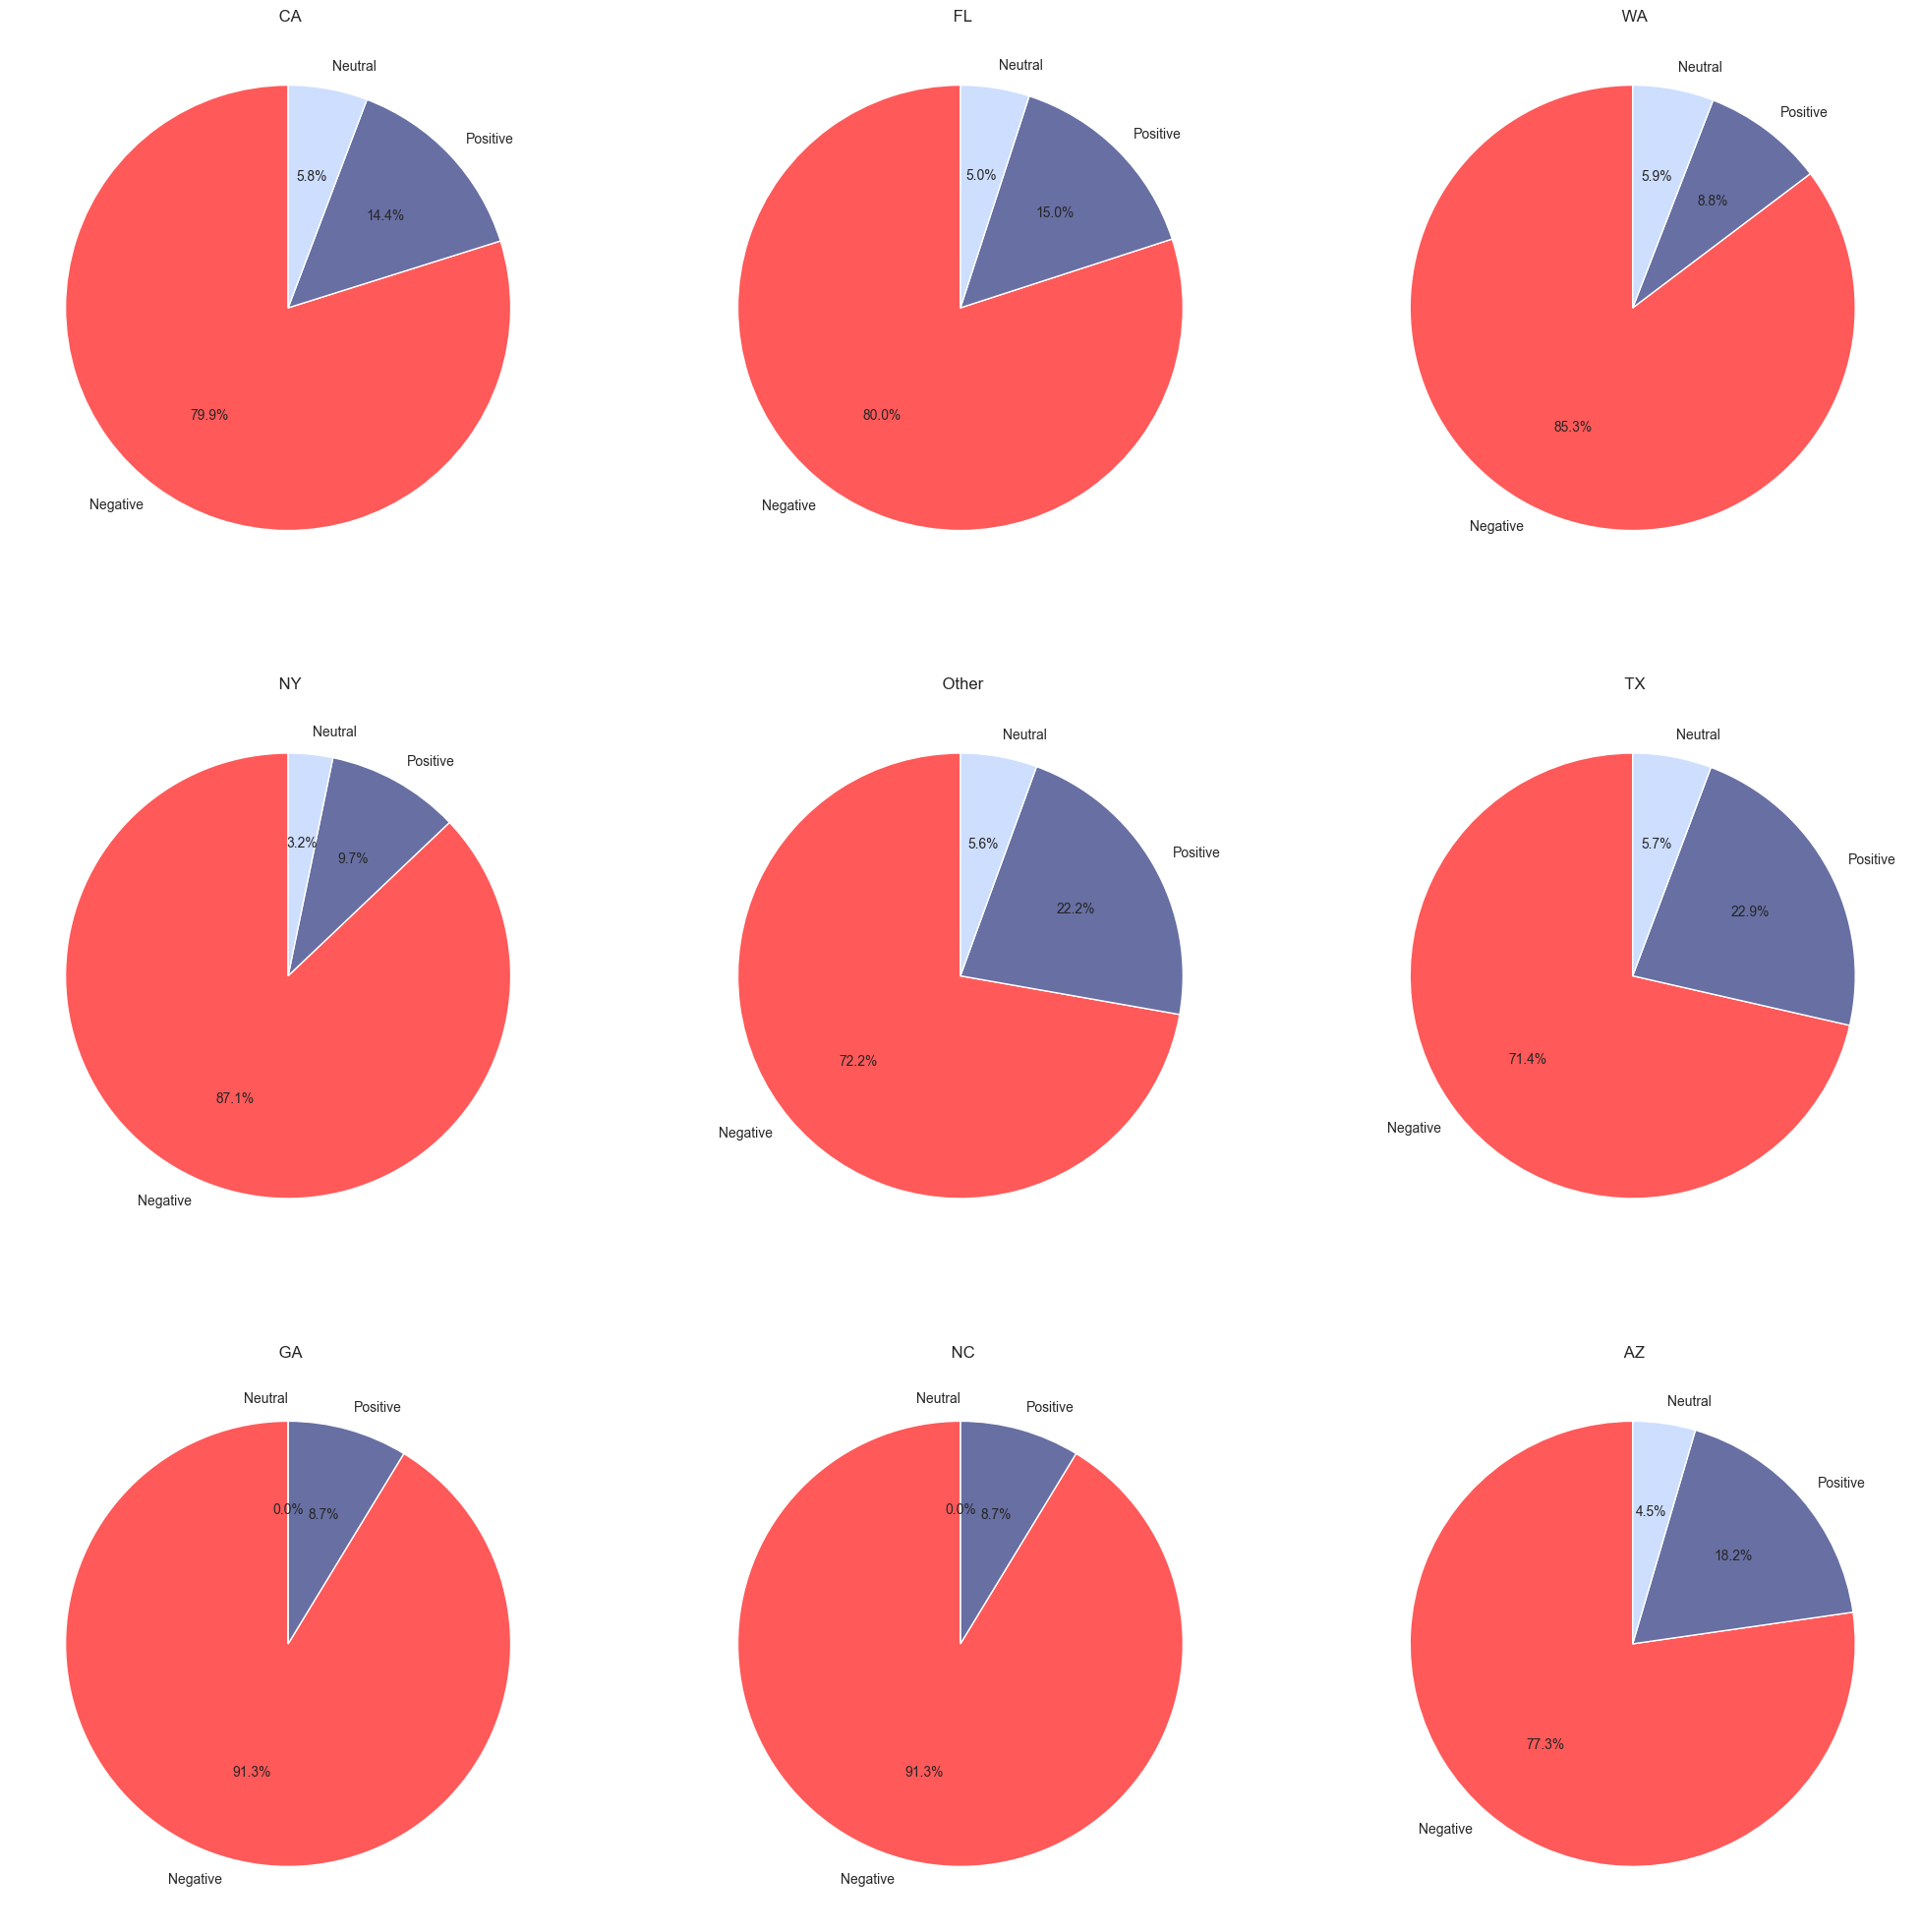

In [16]:
# 각지역별 리뷰의 부정, 긍정, 중립 개수 분포 시각화
fig = plt.figure(figsize = (25, 25))
i=1
features = df.index
for x in features:
    plt.subplot(3, 3, i)
    ax=plt.pie(df.loc[x], labels=df.columns, autopct='%1.1f%%', startangle=90,
        colors=['#FF5959', '#676FA3','#CDDEFF'])
    plt.title(str(x), loc='center')
    i+=1
plt.show()

## 결론 : 모든 지역에 부정적인 리뷰가 더 많다는 것을 알 수 있다.

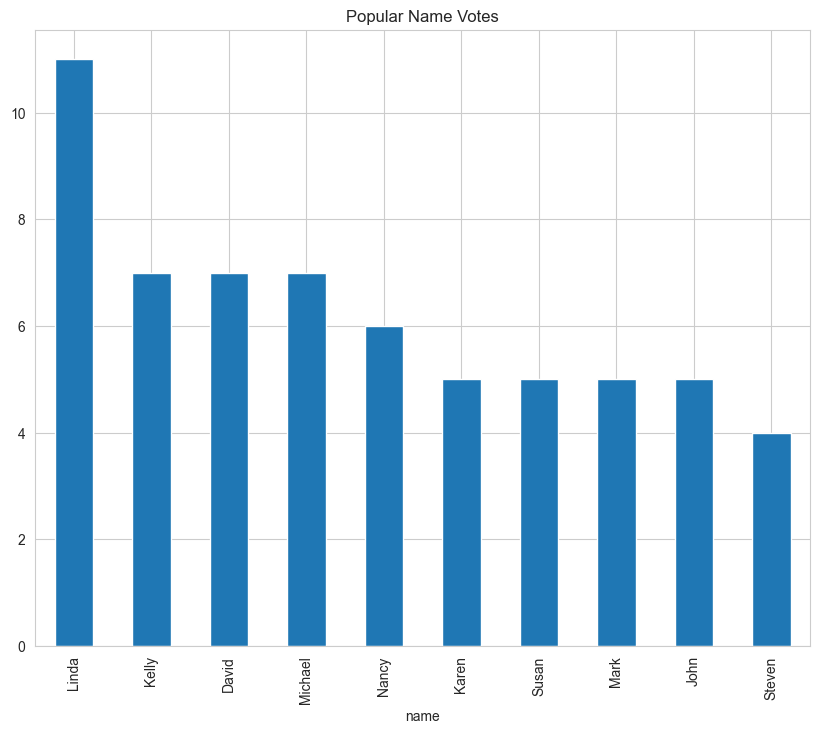

In [17]:
# 누가 가장 많은 리뷰를 남겼나?

plt.figure(figsize=(10,8))
sns.set_style("whitegrid")
data["name"].value_counts().sort_values(ascending= False).head(10).plot.bar()
plt.title("Popular Name Votes");

In [18]:
df = data[["name","Rating"]]
df["Negative"] = df[df["Rating"]==2]["Rating"]
df["Positive"] = df[df["Rating"]==1]["Rating"]
df["Neutral"] = df[df["Rating"]==0]["Rating"]
df.drop("Rating",axis=1,inplace=True)
df=df.groupby("name").count().sort_values(ascending= False,by='Negative').head(9)

C:\Users\user\AppData\Local\Temp\ipykernel_20616\2030778651.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\user\AppData\Local\Temp\ipykernel_20616\2030778651.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



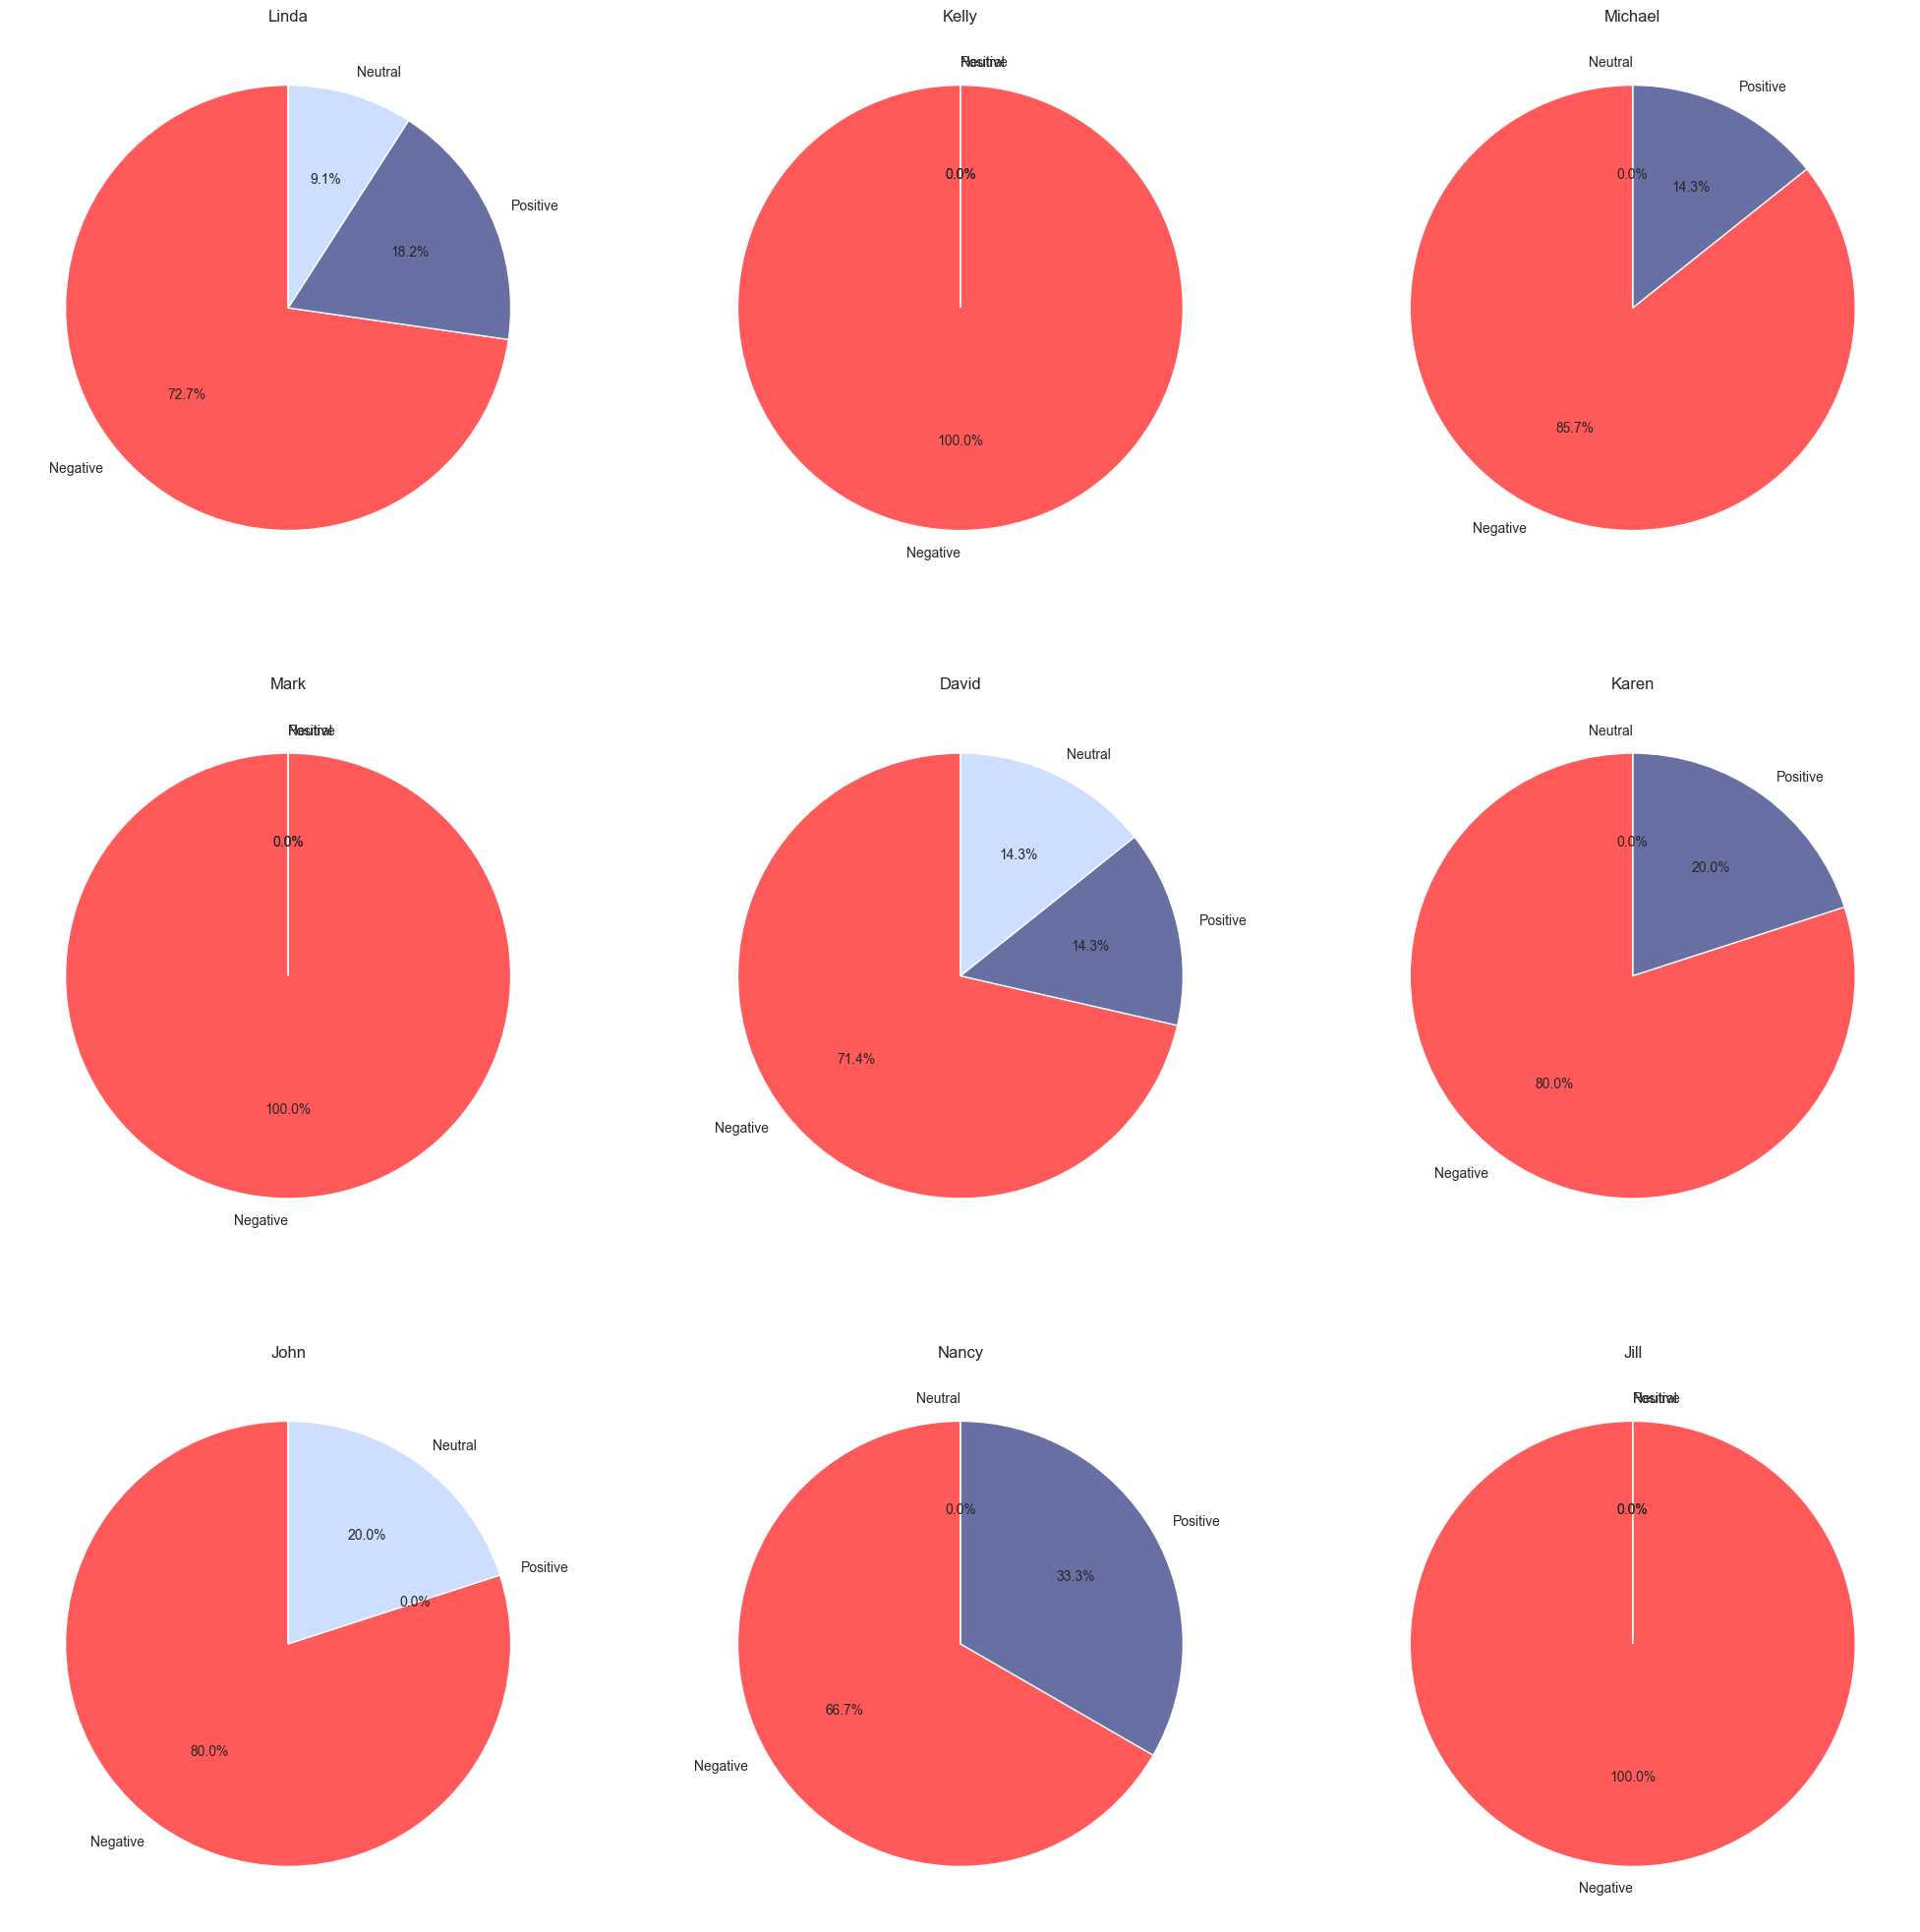

In [19]:
fig = plt.figure(figsize = (25, 25))
i=1
features = df.index
for x in features:
    plt.subplot(3, 3, i)
    ax=plt.pie(df.loc[x], labels=df.columns, autopct='%1.1f%%', startangle=90,
        colors=['#FF5959', '#676FA3','#CDDEFF'])
    plt.title(str(x), loc='center')
    i+=1
plt.show()

In [22]:
# 날짜별로 EDA 실시 일단 년, 월, 일로 나누자


data = data.astype({'Date': 'datetime64[ns]'})
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['DayOfWeek'] = data['Date'].dt.dayofweek

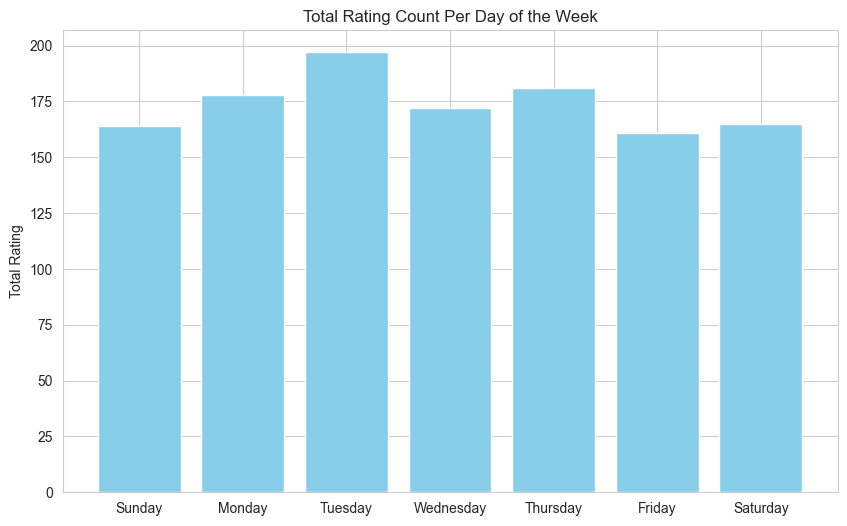

In [23]:
# 

day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
df = data.groupby(['DayOfWeek'])['Rating'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(df['DayOfWeek'], df['Rating'], color='skyblue')
plt.ylabel('Total Rating')
plt.title('Total Rating Count Per Day of the Week')
plt.xticks(df['DayOfWeek'], labels=day_order);

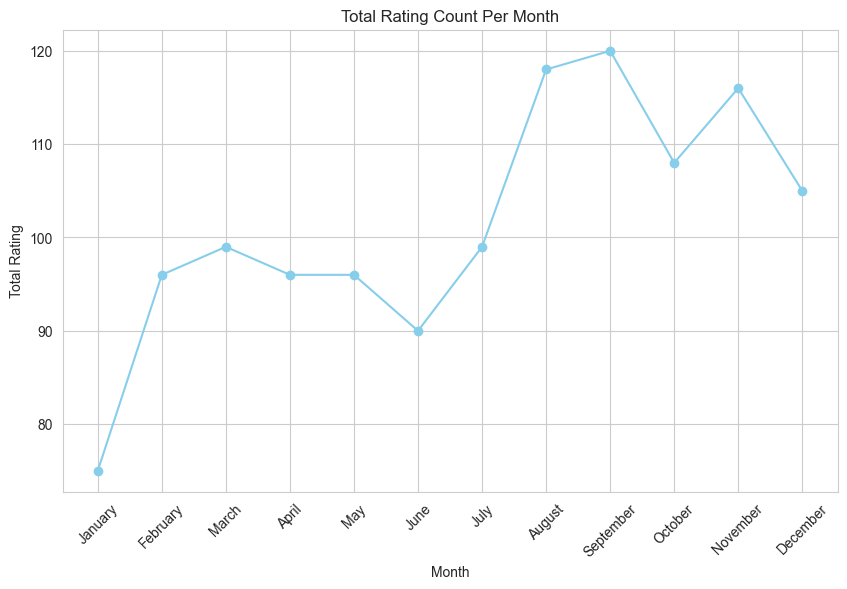

In [24]:
df = data.groupby(['Month'])['Rating'].sum().reset_index()
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(10, 6))
plt.plot(df['Month'], df['Rating'], marker='o', color='skyblue', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Total Rating')
plt.title('Total Rating Count Per Month')

plt.xticks(df['Month'], labels=month_order,rotation=45)
plt.grid(True)
plt.show()

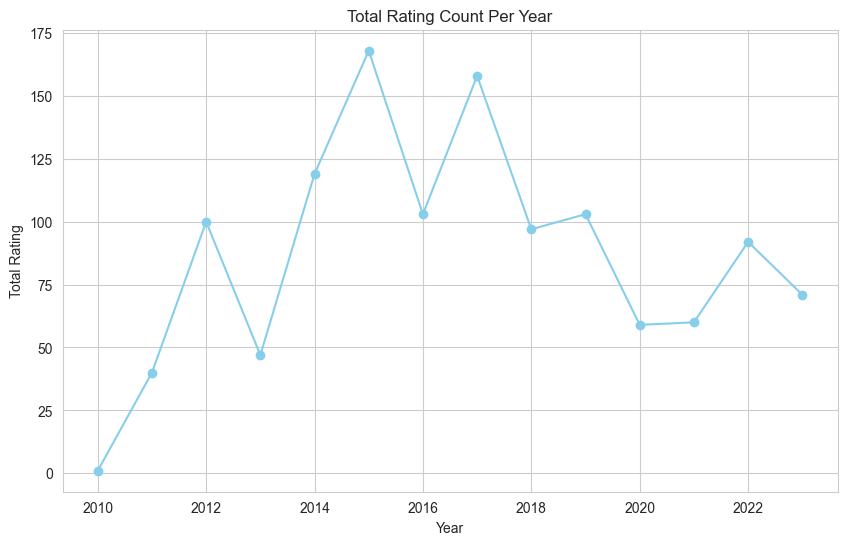

In [25]:
df = data.groupby(['Year'])['Rating'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Rating'], marker='o', color='skyblue', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Total Rating')
plt.title('Total Rating Count Per Year')
plt.grid(True)
plt.show()


In [26]:
# 일별 그래프 시각화

df = data[["DayOfWeek","Rating"]]
df["Negative"] = df[df["Rating"]==2]["Rating"]
df["Positive"] = df[df["Rating"]==1]["Rating"]
df["Neutral"] = df[df["Rating"]==0]["Rating"]
df.drop("Rating",axis=1,inplace=True)
df=df.groupby("DayOfWeek").count()

C:\Users\user\AppData\Local\Temp\ipykernel_20616\3456323245.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\user\AppData\Local\Temp\ipykernel_20616\3456323245.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\user\AppData\Local\Temp\ipykernel_20616\3456323245.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

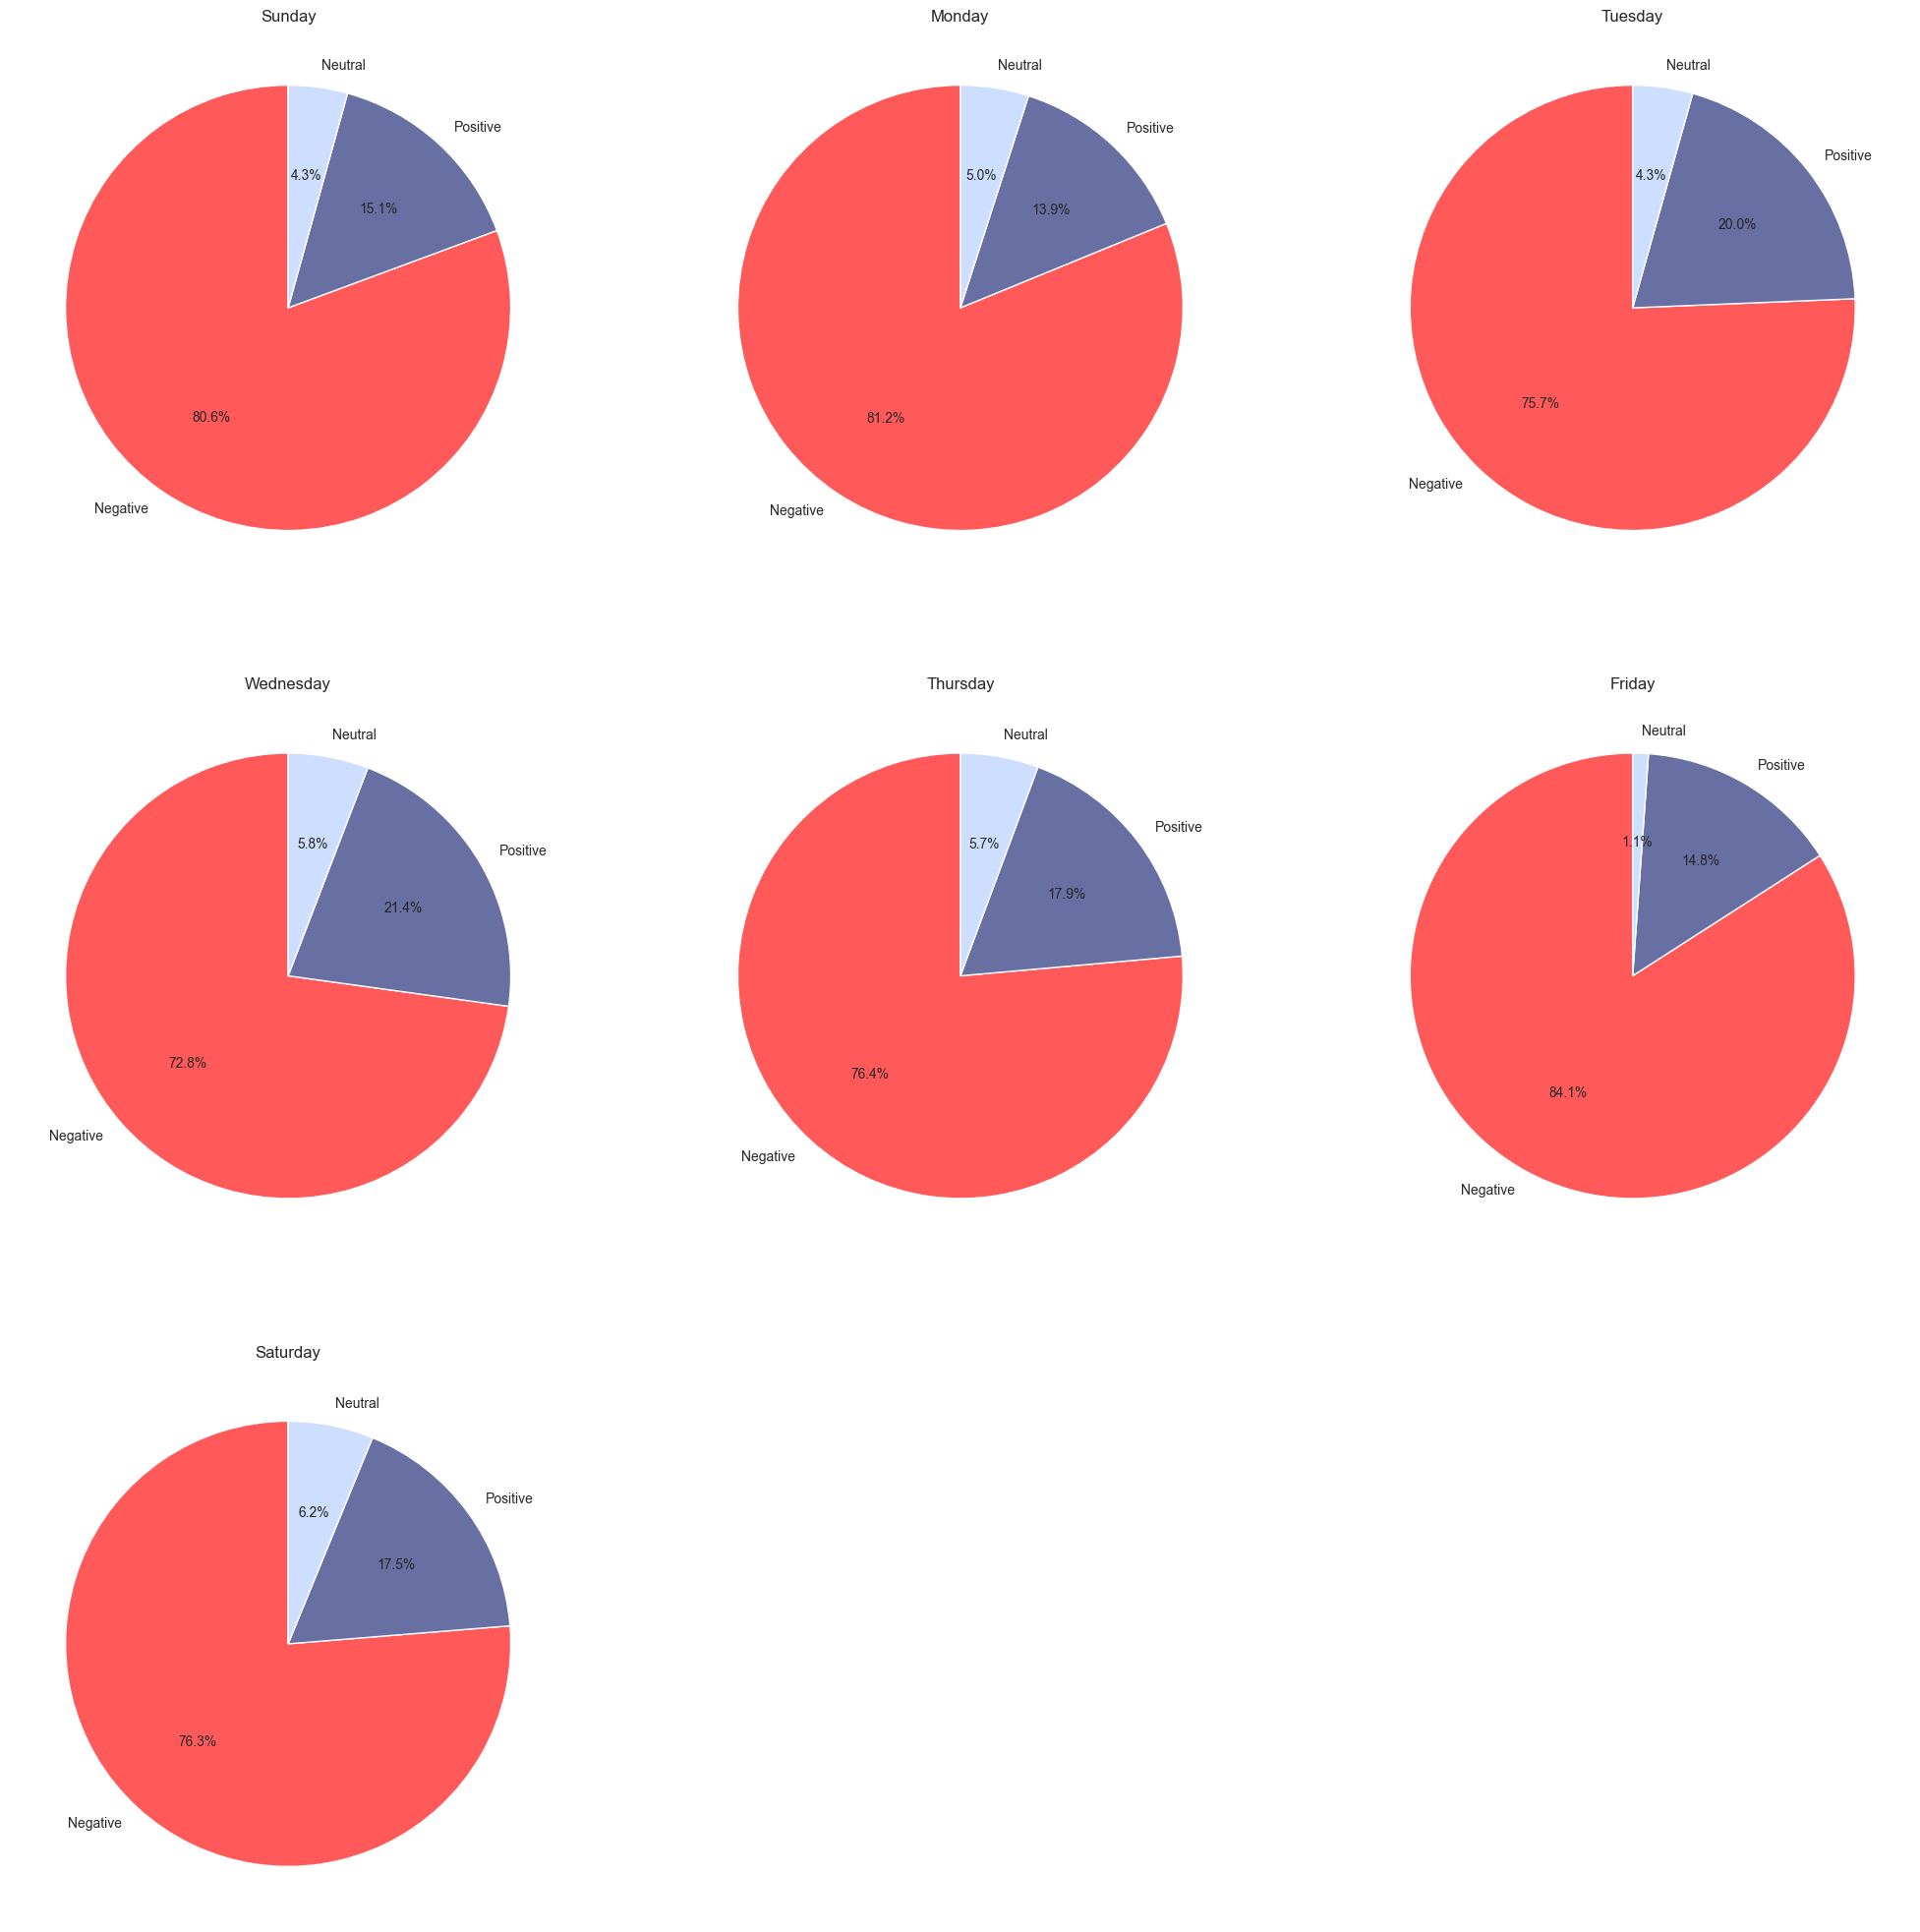

In [27]:
fig = plt.figure(figsize = (25, 25))
i=1
features = df.index
for x in features:
    plt.subplot(3,3, i)
    ax=plt.pie(df.loc[x], labels=df.columns, autopct='%1.1f%%', startangle=90,
        colors=['#FF5959', '#676FA3','#CDDEFF'])
    plt.title(day_order[x], loc='center')
    i+=1
plt.show()

In [28]:
# 월별 그래프 시각화

df = data[["Month","Rating"]]
df["Negative"] = df[df["Rating"]==2]["Rating"]
df["Positive"] = df[df["Rating"]==1]["Rating"]
df["Neutral"] = df[df["Rating"]==0]["Rating"]
df.drop("Rating",axis=1,inplace=True)
df=df.groupby("Month").count()

C:\Users\user\AppData\Local\Temp\ipykernel_20616\1380601778.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\user\AppData\Local\Temp\ipykernel_20616\1380601778.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\user\AppData\Local\Temp\ipykernel_20616\1380601778.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

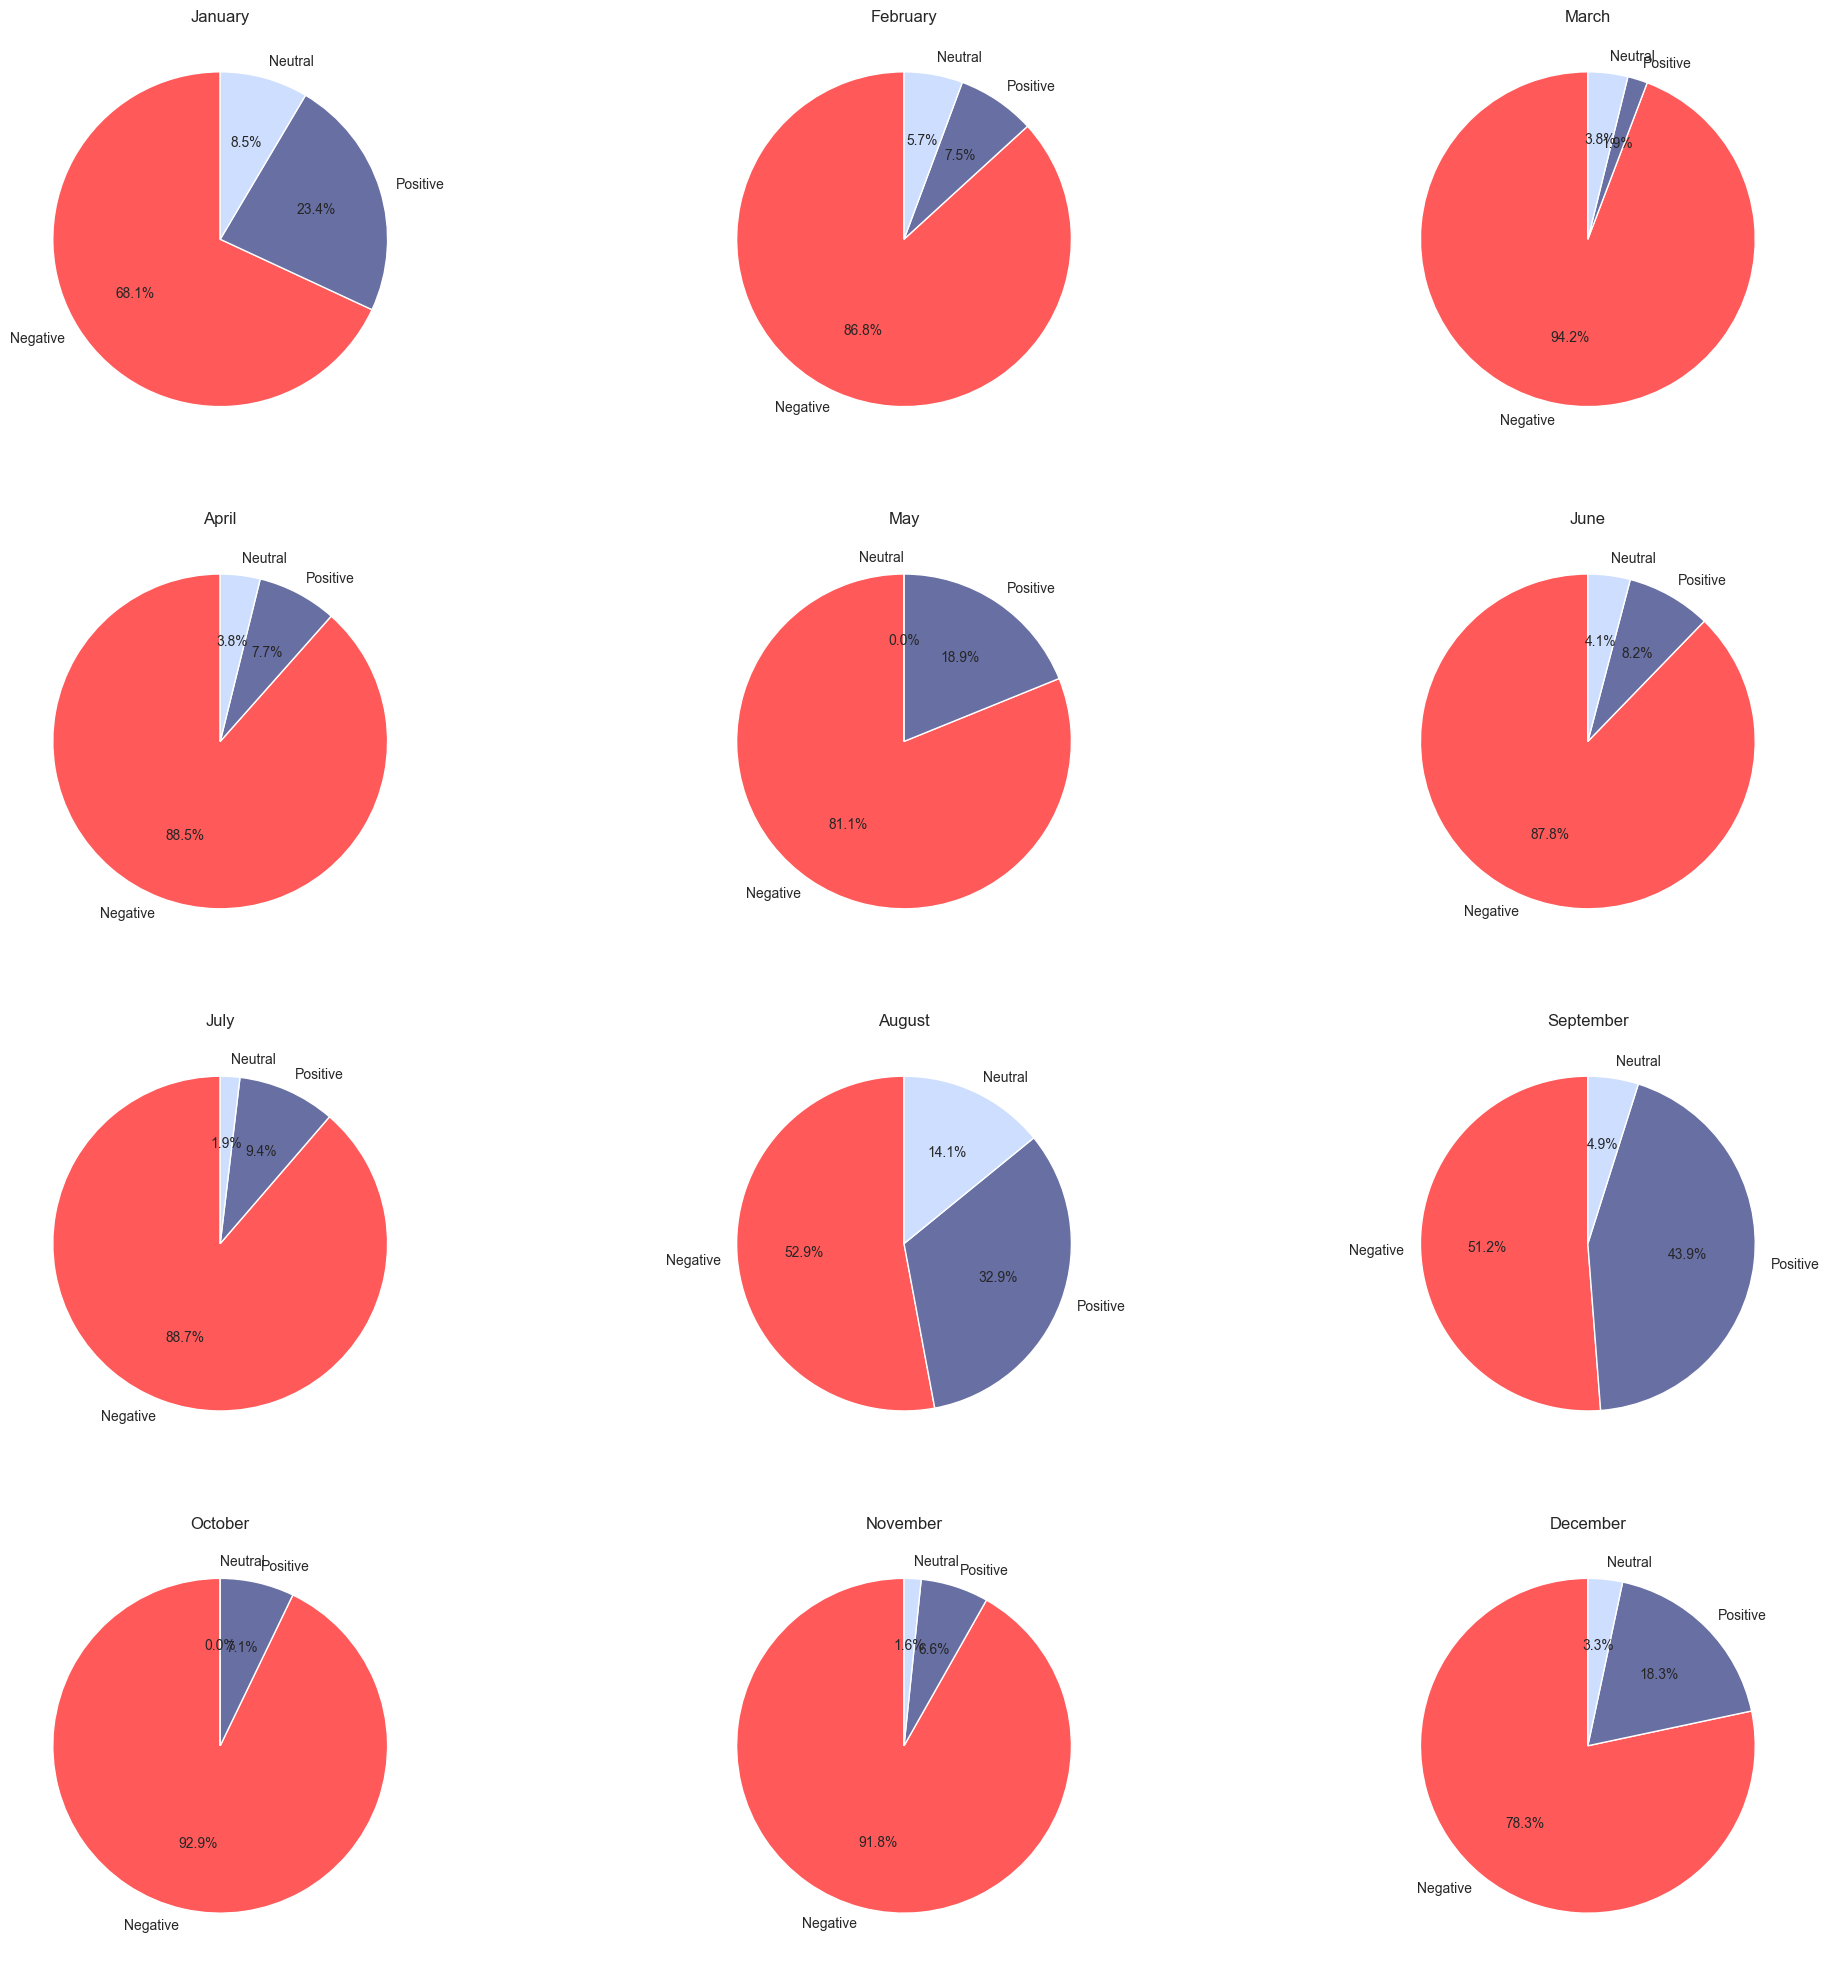

In [29]:
fig = plt.figure(figsize = (25, 25))
i=1
features = df.index
for x in features:
    plt.subplot(4,3, i)
    ax=plt.pie(df.loc[x], labels=df.columns, autopct='%1.1f%%', startangle=90,
        colors=['#FF5959', '#676FA3','#CDDEFF'])
    plt.title(month_order[x-1], loc='center')
    i+=1
plt.show()

In [30]:
# 년별 그래프 시각화

df = data[["Year","Rating"]]
df["Negative"] = df[df["Rating"]==2]["Rating"]
df["Positive"] = df[df["Rating"]==1]["Rating"]
df["Neutral"] = df[df["Rating"]==0]["Rating"]
df.drop("Rating",axis=1,inplace=True)
df=df.groupby("Year").count()[1:]

C:\Users\user\AppData\Local\Temp\ipykernel_20616\996320154.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\user\AppData\Local\Temp\ipykernel_20616\996320154.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\user\AppData\Local\Temp\ipykernel_20616\996320154.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

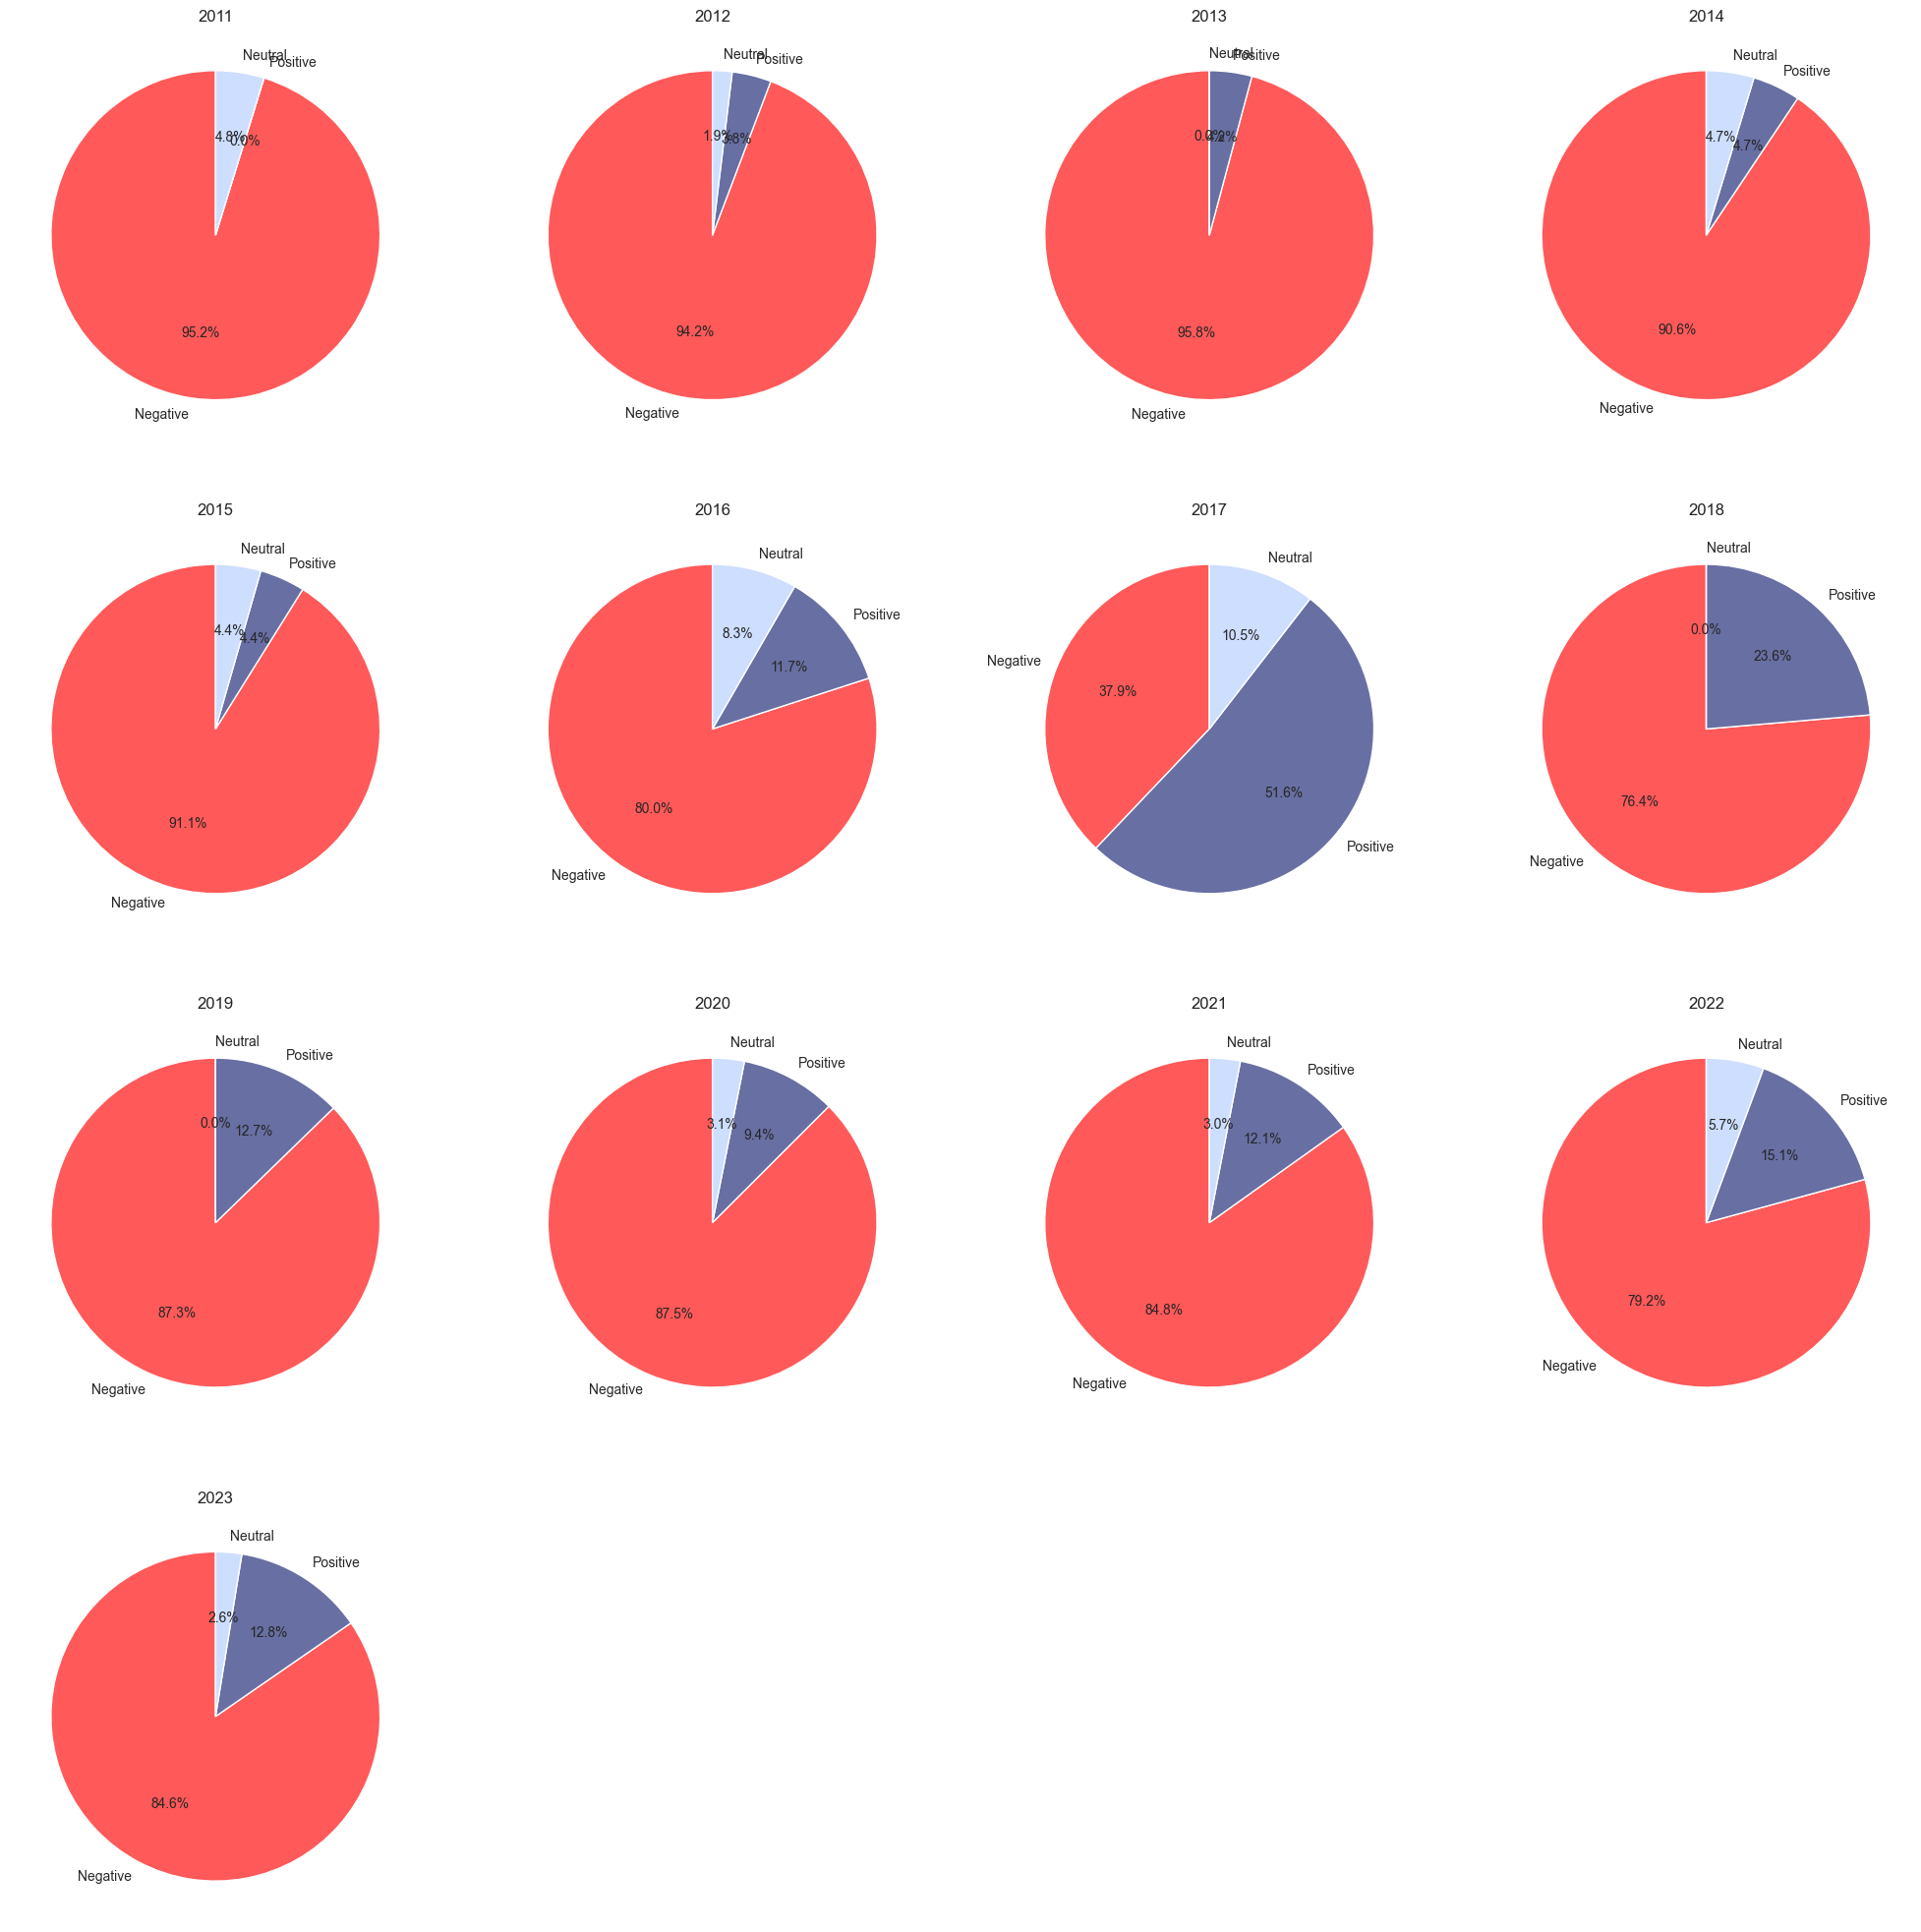

In [31]:
fig = plt.figure(figsize = (25, 25))
i=1
features = df.index
for x in features:
    plt.subplot(4, 4, i)
    ax=plt.pie(df.loc[x], labels=df.columns, autopct='%1.1f%%', startangle=90,
        colors=['#FF5959', '#676FA3','#CDDEFF'])
    plt.title(str(x), loc='center')
    i+=1
plt.show()

In [35]:
data = data[["Review","Rating"]]

In [37]:
# 대, 소문자 변환, 문자가 아닌 것 공백으로 치환

def cleaning (text):
    text = re.sub('[^a-zA-Z]', ' ', str(text).lower().strip())
    text = re.sub('@[A-Za-z0-9_]+', '', text) 
    text = re.sub('#','',text) 
    text = re.sub('RT[\s]+','',text)
    text = re.sub('https?:\/\/\S+', '', text) 
    text = re.sub('\n',' ',text)
    text = emoji.replace_emoji(text, replace='')
    return text

In [38]:
data["Review"]=data["Review"].apply(cleaning)

In [25]:
# 데이터 분리
labels = data["Rating"]
training = data["Review"]

In [41]:
# 표제어 추출
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

def lemm(data):
    wordnet = WordNetLemmatizer()
    lemmanized = []
    for i in range(len(data)):
        lemmed = []
        words = word_tokenize(data['Review'].iloc[i])
        for w in words:
            lemmed.append(wordnet.lemmatize(w))
        lemmanized.append(lemmed)

    data['lemmanized'] = lemmanized
    data['Review'] = data['lemmanized'].apply(' '.join)
    data=data.drop("lemmanized",axis=1)
    return data
data=lemm(data)

In [42]:
data.head()

Review  Rating
0  amber and ladonna at the starbucks on southwes...       1
1  at the starbucks by the fire station on in alt...       1
2  i just wanted to go out of my way to recognize...       1
3  me and my friend were at starbucks and my card...       1
4  i m on this kick of drinking cup of warm water...       1

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(training, labels, test_size=0.2, random_state=42)

In [43]:
labels = data["Rating"]
training = data["Review"]

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(training, labels, test_size=0.2, random_state=42)

In [46]:
# TF-IDF 벡터화

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [47]:
# 로지스틱 회귀 분석

model= LogisticRegression(multi_class="multinomial")
model.fit(X_train_vec,y_train)
preds =model.predict(X_test_vec)
print(accuracy_score(y_test,preds))

0.8156028368794326


In [48]:
# 의사 결정 트리

model = DecisionTreeClassifier()
model.fit(X_train_vec,y_train)
preds = model.predict(X_test_vec)
print(accuracy_score(y_test,preds))

0.7588652482269503


In [49]:
# 랜덤 포레스트

model = RandomForestClassifier()
model.fit(X_train_vec,y_train)
preds = model.predict(X_test_vec)
print(accuracy_score(y_test,preds))

0.8439716312056738


In [50]:
# SVM 서포트 벡터머신

model = LinearSVC()
model.fit(X_train_vec,y_train)
preds = model.predict(X_test_vec)
print(accuracy_score(y_test,preds))

0.8794326241134752


C:\Users\user\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



In [51]:
# Navie bayes 네이브 베이즈

model = MultinomialNB()
model.fit(X_train_vec,y_train)
preds = model.predict(X_test_vec)
print(accuracy_score(y_test,preds))

0.7446808510638298
